### Автор: Черная Анастасия

### Telegram: @ChernayaAnastasia

К сожалению, я не сохранила свою лучшую модель, поэтому Accuracy обученной модели ниже не будет в точности как на leaderboard. Но все равно покажу свое решение, которое пробило порог в 0.5. Вынесла в отдельную тетрадку, чтобы не засорять здесь многочисленными экспериментами (менее удачными) код.

In [1]:
! pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 10.0 MB/s eta 0:00:00


In [5]:
import os
import random
import pandas as pd
import numpy as np
import sys
import re
import matplotlib.pyplot as plt
import emoji

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Dict
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW

from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup, AutoConfig



RANDOM_SEED = 42
PATH_COLAB = '/content/drive/MyDrive/Colab Notebooks/DLS_EcomTech_Workshop/competition/'

# Data Load

In [6]:
url_train = 'https://drive.google.com/uc?export=download&id=1tv9pCk2TFOnwZ775VtPRLKfd94BqwAaN'
url_test = 'https://drive.google.com/uc?export=download&id=1-88Uw8DIQZR4qN6KzxwbDL1TZ40NIJVA'

train_data = pd.read_csv(url_train, index_col=0)
test_data = pd.read_csv(url_test, index_col=0)

train_data.head()

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,text_corr,llm_generated
index,,,,,,,,,,,,,,,,,,,,,
5652.0,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"Маленький выбор товаров, хотелось бы ассортиме...",0
18092.0,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Быстро,0
13845.0,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Доставка постоянно задерживается,0
25060.0,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Наценка и ассортимент расстраивают,0
1428.0,6.0,"{PRICE,PROMOTIONS}",Можно немного скинуть минимальную сумму заказа...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Можно немного скинуть минимальную сумму заказа...,0


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5173 entries, 5652.0 to nan
Data columns (total 55 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   assessment      4623 non-null   float64
 1   tags            4612 non-null   object 
 2   text            5173 non-null   object 
 3   trend_id_res0   5173 non-null   int64  
 4   trend_id_res1   5173 non-null   int64  
 5   trend_id_res2   5173 non-null   int64  
 6   trend_id_res3   5173 non-null   int64  
 7   trend_id_res4   5173 non-null   int64  
 8   trend_id_res5   5173 non-null   int64  
 9   trend_id_res6   5173 non-null   int64  
 10  trend_id_res7   5173 non-null   int64  
 11  trend_id_res8   5173 non-null   int64  
 12  trend_id_res9   5173 non-null   int64  
 13  trend_id_res10  5173 non-null   int64  
 14  trend_id_res11  5173 non-null   int64  
 15  trend_id_res12  5173 non-null   int64  
 16  trend_id_res13  5173 non-null   int64  
 17  trend_id_res14  5173 non-null   in

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9015 entries, 1 to 16998
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       9015 non-null   int64  
 1   assessment  9015 non-null   float64
 2   tags        8983 non-null   object 
 3   text        9014 non-null   object 
 4   text_corr   9014 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 422.6+ KB


In [9]:
train_data.describe().T.sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
assessment,4623.0,3.289206,2.163499,0.0,2.0,3.0,6.0,6.0
trend_id_res0,5173.0,0.161802,0.368304,0.0,0.0,0.0,0.0,1.0
trend_id_res12,5173.0,0.120626,0.325724,0.0,0.0,0.0,0.0,1.0
trend_id_res2,5173.0,0.115407,0.319543,0.0,0.0,0.0,0.0,1.0
llm_generated,5173.0,0.106321,0.308278,0.0,0.0,0.0,0.0,1.0
trend_id_res27,5173.0,0.102455,0.303275,0.0,0.0,0.0,0.0,1.0
trend_id_res28,5173.0,0.081191,0.273154,0.0,0.0,0.0,0.0,1.0
trend_id_res3,5173.0,0.069785,0.254810,0.0,0.0,0.0,0.0,1.0
trend_id_res19,5173.0,0.069592,0.254483,0.0,0.0,0.0,0.0,1.0
trend_id_res1,5173.0,0.067079,0.250183,0.0,0.0,0.0,0.0,1.0


In [10]:
targets_list = [col for col in train_data.columns if col.startswith('trend_id_res')]

Распределение классов в обучающем датасете

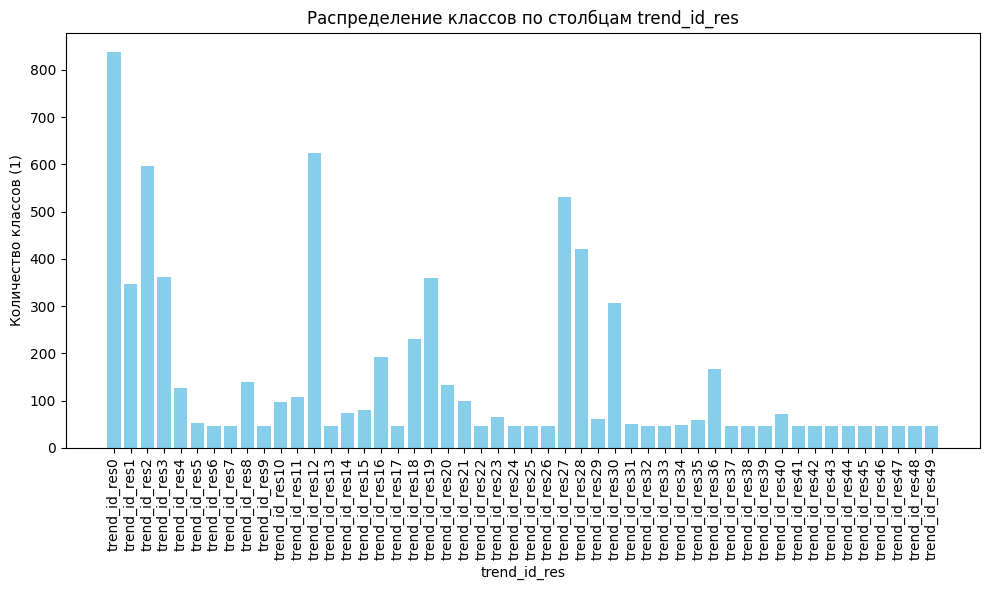

In [11]:
class_sums = train_data[targets_list].sum()

plt.figure(figsize=(10, 6))
plt.bar(class_sums.index, class_sums.values, color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('trend_id_res')
plt.ylabel('Количество классов (1)')
plt.title('Распределение классов по столбцам trend_id_res')
plt.tight_layout()
plt.show()

# Preprocess data

In [12]:
def preprocess_text(text):
    if not isinstance(text, str):
        return text
    else:
        text = re.sub(r'ё', 'е', text)
        text = re.sub(r'\n|\s{2,}', ' ', text)
        text = re.sub(r'(?<!\d)([.,:!?\)])(?=[а-яёa-z№\d])', r"\1 ", text)
        text = re.sub(r'\[NUM\](?![.,:!?\\)])([а-яёa-z№\d₽%])', r'[NUM] \1', text) #[NUM]минут
        text = emoji.demojize(text, language='ru')

        return text.lower().strip()

In [13]:
train_data['text_cleaned'] = train_data.text_corr.apply(preprocess_text)
test_data['text_cleaned'] = test_data.text_corr.apply(preprocess_text)

In [14]:
train_data[['text_corr','text_cleaned']]

,text_corr,text_cleaned
index,,
5652.0,"Маленький выбор товаров, хотелось бы ассортиме...","маленький выбор товаров, хотелось бы ассортиме..."
18092.0,Быстро,быстро
13845.0,Доставка постоянно задерживается,доставка постоянно задерживается
25060.0,Наценка и ассортимент расстраивают,наценка и ассортимент расстраивают
1428.0,Можно немного скинуть минимальную сумму заказа...,можно немного скинуть минимальную сумму заказа...
...,...,...
NaN,"Попросила, чтобы замороженные продукты не клал...","попросила, чтобы замороженные продукты не клал..."
NaN,"Указала, чтобы не заменяли продукты без моего ...","указала, чтобы не заменяли продукты без моего ..."
NaN,"Прошу не класть хлеб с тяжёлыми продуктами, но...","прошу не класть хлеб с тяжелыми продуктами, но..."


# Train Test split

In [15]:
train_split, val_split = train_test_split(train_data, test_size=0.15, random_state=RANDOM_SEED,
                                          shuffle = True)

In [16]:
train_split.shape

(4397, 56)

In [17]:
val_split.shape

(776, 56)

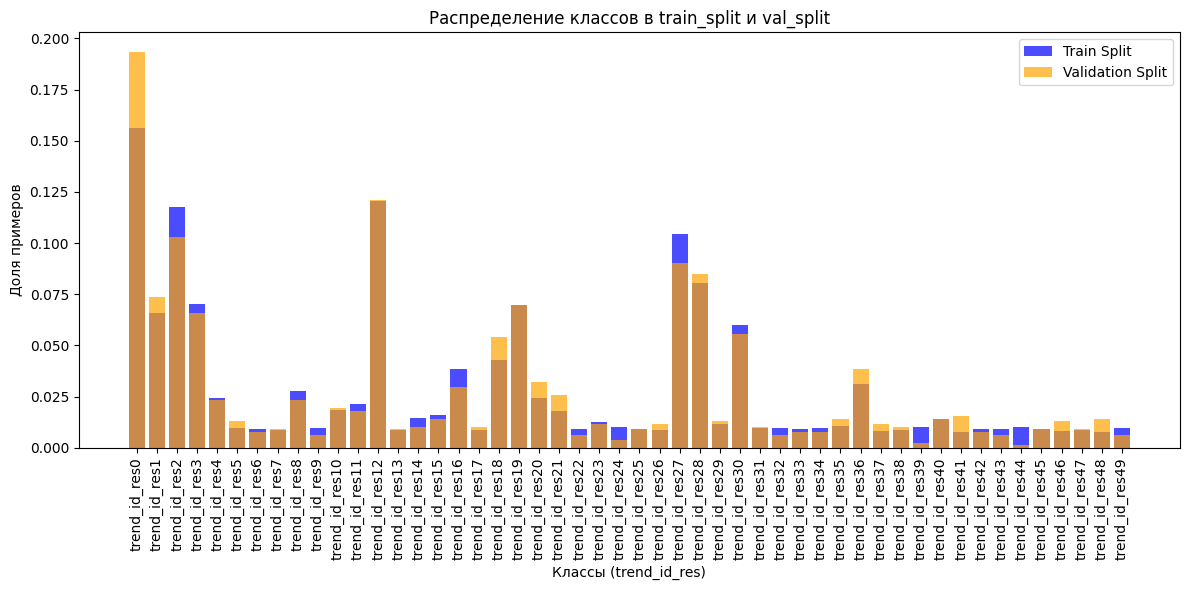

In [18]:
# Подсчет количества примеров для каждого класса в train_split и val_split
train_distribution = train_split[[f"trend_id_res{i}" for i in range(50)]].sum()
val_distribution = val_split[[f"trend_id_res{i}" for i in range(50)]].sum()

# Нормализация распределения, чтобы показать доли
train_distribution_normalized = train_distribution / len(train_split)
val_distribution_normalized = val_distribution / len(val_split)

# Построение гистограмм
fig, ax = plt.subplots(figsize=(12, 6))

# Гистограмма для train_split
ax.bar(range(50), train_distribution_normalized, alpha=0.7, label='Train Split', color='blue')

# Гистограмма для val_split
ax.bar(range(50), val_distribution_normalized, alpha=0.7, label='Validation Split', color='orange')

ax.set_title('Распределение классов в train_split и val_split')
ax.set_xlabel('Классы (trend_id_res)')
ax.set_ylabel('Доля примеров')
ax.legend()

plt.xticks(range(50), [f"trend_id_res{i}" for i in range(50)], rotation=90)
plt.tight_layout()
plt.show();

# ModelForClassification

In [19]:
class ModelForClassification(torch.nn.Module):

    def __init__(self, model_path: str, config: Dict, custom_config: Dict):
        super(ModelForClassification, self).__init__()
        self.model_name = model_path
        self.config = config
        self.custom_config = custom_config
        self.n_classes = custom_config['num_classes']
        self.dropout_rate = custom_config['dropout_rate']
        self.bert = AutoModel.from_pretrained(self.model_name, output_hidden_states=True)
        self.pre_classifier = torch.nn.Linear(self.config.hidden_size * 4, 768)
        self.dropout = torch.nn.Dropout(self.dropout_rate)
        self.classifier = torch.nn.Linear(768, self.n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        all_hidden_states = torch.stack(output[2])
        concatenate_pooling = torch.cat((all_hidden_states[-1],
                                          all_hidden_states[-2],
                                          all_hidden_states[-3],
                                          all_hidden_states[-4]), -1)
        concatenate_pooling = concatenate_pooling[:, 0]

        # Классификационная голова
        logits = self.pre_classifier(concatenate_pooling)
        dropout_state = self.dropout(logits)
        output = self.classifier(dropout_state)

        return output

# CustomDataset

In [20]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, max_seq_len):
        self.text = dataframe['text_cleaned'].tolist()
        self.tokenizer = tokenizer
        self.data = dataframe
        self.targets = None
        if 'trend_id_res0' in dataframe.columns:
          self.targets = self.targets = self.data[[f"trend_id_res{i}" for i in range(50)]].values
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        if len(text) == 0:
          raise ValueError(f"Text at index {index} is empty")

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_seq_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        if self.targets is not None:
            return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'text': text
        }

        else:
            return {
                'input_ids': inputs['input_ids'].flatten(),
                'attention_mask': inputs['attention_mask'].flatten()
            }

    def __len__(self) -> int:
      return len(self.text)

# CustomTrainer

In [21]:
class CustomTrainer():
    def __init__(self, config: Dict):
        self.config = config
        self.n_epochs = config['n_epochs']
        self.device = config['device']
        self.history = None
        self.verbose = config.get('verbose', True)

    def fit(self, model, train_dataloader, val_dataloader):
        self.model = model
        best_val_accuracy = float('-inf')
        self.train_loader = train_dataloader
        self.optimizer = AdamW(model.parameters(), self.config['lr'])
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * self.n_epochs
        )
        self.loss_fn = torch.nn.BCEWithLogitsLoss().to(self.device)

        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_accuracy': []
        }

        for epoch in range(self.n_epochs):
            print(f"Epoch {epoch + 1}/{self.n_epochs}")
            train_info = self.train_epoch(train_dataloader)
            val_info = self.val_epoch(val_dataloader)
            self.history['train_loss'].append(train_info['loss'])
            self.history['val_loss'].append(val_info['loss'])
            self.history['val_accuracy'].append(val_info['accuracy'])

            if val_info['accuracy'] > best_val_accuracy:
                best_val_accuracy = val_info['accuracy']

                checkpoint = {
                    "config": model.config,
                    "trainer_config": self.config,
                    "model_name": model.model_name,
                    "model_state_dict": model.state_dict()
                }
                torch.save(checkpoint, f'bert_epoch{epoch}.ckpt')

        return model.eval()

    def train_epoch(self, train_dataloader):
        self.model.to(self.device)
        self.model.train()
        losses = []
        if self.verbose:
            train_dataloader = tqdm(train_dataloader)

        for batch in train_dataloader:
            ids = batch['input_ids'].to(self.device)
            mask = batch['attention_mask'].to(self.device)
            targets = batch['targets'].to(self.device)

            outputs = self.model(ids, mask)
            loss = self.loss_fn(outputs, targets)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()

            loss_val = loss.item()
            losses.append(loss_val)

        print('Train loss: ', np.mean(losses))
        return {'loss': np.mean(losses)}

    def val_epoch(self, val_dataloader):
        self.model.eval()
        all_labels = []
        all_preds = []
        losses = []
        if self.verbose:
            val_dataloader = tqdm(val_dataloader)

        with torch.no_grad():
            for batch in val_dataloader:
                ids = batch['input_ids'].to(self.device)
                mask = batch['attention_mask'].to(self.device)
                targets = batch['targets'].to(self.device)

                outputs = self.model(ids, mask)

                # Вычисление потерь
                loss = self.loss_fn(outputs, targets).item()
                losses.append(loss)

                # Получение предсказаний
                preds = torch.sigmoid(outputs).cpu().detach().numpy().round()

                # Сохранение предсказаний и истинных значений
                all_preds.append(preds)
                all_labels.append(targets.cpu().numpy())

        # Преобразование предсказаний и истинных меток в numpy для использования accuracy_score
        all_labels = np.concatenate(all_labels, axis=0)
        all_preds = np.concatenate(all_preds, axis=0)

        # Подсчет accuracy на основе полного совпадения всех меток для каждого примера
        accuracy = accuracy_score(all_labels, all_preds)

        print('Val loss:', np.mean(losses))
        print('Accuracy:', accuracy)

        return {
            'accuracy': accuracy,
            'loss': np.mean(losses)
        }

    def predict(self, test_dataloader):
        if not self.model:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        prediction_probs = []

        with torch.no_grad():
            for batch in test_dataloader:
                ids = batch['input_ids'].to(self.device)
                mask = batch['attention_mask'].to(self.device)
                outputs = self.model(ids, mask)
                outputs = torch.sigmoid(outputs).detach().cpu()

                # thresholding at 0.5
                preds = outputs.round()

                predictions.extend(preds)
                prediction_probs.extend(outputs)


        predictions = torch.stack(predictions).cpu().numpy()
        prediction_probs = torch.stack(prediction_probs).cpu().numpy()

        return predictions, prediction_probs

    def save(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        checkpoint = {
            "config": self.model.config,
            "model_name": self.model.model_name,
            "model_state_dict": self.model.state_dict()
        }
        torch.save(checkpoint, path)

    def save_model_weights(self, path: str):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        torch.save(self.model.state_dict(), path)

    def plot_history(self):
        import matplotlib.pyplot as plt

        if self.history is None:
            raise RuntimeError("History is not available. Train the model first.")

        train_loss = self.history['train_loss']
        val_loss = self.history['val_loss']
        val_acc = self.history['val_accuracy']

        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, 'bo', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

    @classmethod
    def load(cls, path: str):
        ckpt = torch.load(path)
        keys = ["config", "trainer_config", "model_state_dict"]
        for key in keys:
            if key not in ckpt:
                raise RuntimeError(f"Missing key {key} in checkpoint")
        new_model = ModelForClassification(
            ckpt['model_name'],
            ckpt["config"]
        )
        new_model.load_state_dict(ckpt["model_state_dict"])
        new_trainer = cls(ckpt["trainer_config"])
        new_trainer.model = new_model
        new_trainer.model.to(new_trainer.device)
        return new_trainer

In [22]:
train_data.text_cleaned.str.split().str.len().max()

52

In [23]:
test_data.text_cleaned.str.split().str.len().max()

52.0

# Loading tokenizer

Для получения эмбедингов лучшей моделью в моей выборке экспериментов оказалась ai-forever/ruBert-base.

In [25]:
tokenizer = AutoTokenizer.from_pretrained('ai-forever/ruBert-base')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Creating Datasets, DataLoaders for train and validation

In [26]:
MAX_LEN = 100
BATCH_SIZE = 64
train_dataset = CustomDataset(train_split, tokenizer, MAX_LEN)
val_dataset = CustomDataset(val_split, tokenizer, MAX_LEN)
train_params = {"batch_size": BATCH_SIZE,
                "shuffle": True,
                "num_workers": 0
                }

test_params = {"batch_size": BATCH_SIZE,
               "shuffle": False,
               "num_workers": 0
               }

train_dataloader = DataLoader(train_dataset, **train_params)
val_dataloader = DataLoader(val_dataset, **test_params)

# Model Initialization with Custom Configuration for Classification

In [27]:
config = AutoConfig.from_pretrained('ai-forever/ruBert-base', return_dict=True)
config.update({'output_hidden_states': True})

custom_config = {"num_classes":len(targets_list),
               "dropout_rate": 0.1}

model = ModelForClassification(
    "ai-forever/ruBert-base",
    config=config,
    custom_config=custom_config
)

pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

# Fitting the Model

In [28]:
trainer_config = {
    "lr": 2e-4,
    "n_epochs": 20,
    "weight_decay": 1e-06,
    "warmup_steps": 0,
    "batch_size": BATCH_SIZE,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": RANDOM_SEED,
}
t = CustomTrainer(trainer_config)

t.fit(
    model,
    train_dataloader,
    val_dataloader
)

Epoch 1/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.11559385979089185


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.07945391936944081
Accuracy: 0.25128865979381443
Epoch 2/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.06016176031983417


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.05701260813153707
Accuracy: 0.43943298969072164
Epoch 3/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.04003841006129548


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.05635898932814598
Accuracy: 0.49097938144329895
Epoch 4/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.027103366465240284


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.05405475428471199
Accuracy: 0.5077319587628866
Epoch 5/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.017581565130124058


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.05998499089708695
Accuracy: 0.5038659793814433
Epoch 6/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.011616416471213966


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.0605244948886908
Accuracy: 0.5283505154639175
Epoch 7/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.007678728874610818


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.06549398486430828
Accuracy: 0.5167525773195877
Epoch 8/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.00545872972967724


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.06634671126420681
Accuracy: 0.5180412371134021
Epoch 9/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0037909296030799546


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.0724755568573108
Accuracy: 0.5103092783505154
Epoch 10/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.002478966845428922


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.07374073966191365
Accuracy: 0.5425257731958762
Epoch 11/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0020420993138374624


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.07530163572384761
Accuracy: 0.5451030927835051
Epoch 12/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0014708982156319678


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.0791728447836179
Accuracy: 0.5360824742268041
Epoch 13/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.001156510583182419


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.07997668792422001
Accuracy: 0.5399484536082474
Epoch 14/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0010664434555202615


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08058022994261521
Accuracy: 0.5360824742268041
Epoch 15/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0009571651977054991


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08230913201203713
Accuracy: 0.538659793814433
Epoch 16/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0009007014178559589


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08163800291143931
Accuracy: 0.5399484536082474
Epoch 17/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0008134316191991683


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08321336828745328
Accuracy: 0.5425257731958762
Epoch 18/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0007609590646335046


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08375070444666423
Accuracy: 0.5412371134020618
Epoch 19/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0007312159291029894


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08388823213485572
Accuracy: 0.5425257731958762
Epoch 20/20


  0%|          | 0/69 [00:00<?, ?it/s]

Train loss:  0.0007068065587309716


  0%|          | 0/13 [00:00<?, ?it/s]

Val loss: 0.08410943843997441
Accuracy: 0.5451030927835051


ModelForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

# Getting the predictions

In [30]:
test_dataset = CustomDataset(test_data, tokenizer, MAX_LEN)
test_dataloader = DataLoader(test_dataset, **test_params)

In [31]:
predictions, prediction_probs = t.predict(test_dataloader)
predictions.shape

(9015, 50)

In [32]:
res = pd.DataFrame(
    np.hstack([test_data["index"].values.reshape(test_data.shape[0], 1), predictions]),
    columns=["index"] + [f"trend_id_res{i}" for i in range(50)]
)

res["index"] = res["index"].astype('int64')

res

,index,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,3135,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,23511,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9010,3523,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9011,24925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9012,6327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9013,530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Создаем столбец 'target', записывая номера классов, где есть 1, через пробел
res['target'] = res[targets_list].apply(lambda row: ' '.join(str(i) for i, val in enumerate(row) if val == 1), axis=1)
submission = res[['index', 'target']]
submission.head()

,index,target
0,3135,1 2 12
1,4655,12
2,22118,2 35
3,23511,0
4,45,18


In [54]:
test_data.loc[1][['index','text']].tolist()

[3135,
 'Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов']

In [44]:
def visualize_predictions(prediction_probs, sample_idx):
    """
    Визуализирует вероятности принадлежности образца к классам.

    Args:
        prediction_probs (numpy.ndarray): Вероятности для всех образцов.
        sample_idx (int): Индекс образца для визуализации.
    """
    probs = prediction_probs[sample_idx]

    plt.bar(range(len(probs)), probs, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Probability')
    plt.title(f'Class probabilities for sample {sample_idx}')

    plt.xticks(np.arange(len(probs)), labels=[f'Class {i}' for i in range(len(probs))], rotation=90, fontsize=8)

    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show();

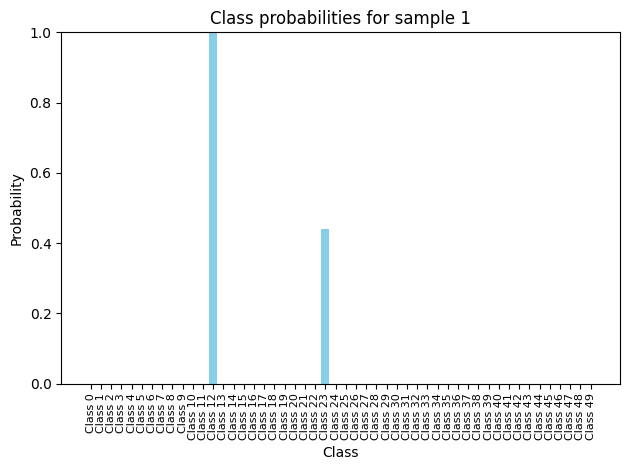

In [56]:
sample_idx = 1
visualize_predictions(prediction_probs, sample_idx)

In [57]:
#submission.to_csv(os.path.join(PATH_COLAB, "rubert_augmented_spel_checked_submission_for_check.csv"), index=False)

In [ ]:
#t.save(os.path.join(PATH_COLAB, "rubert_model_augmented_for_check.ckpt"))

In [ ]:
#t.save_model_weights(os.path.join(PATH_COLAB, "rubert_model_augmented_for_check.ckpt"))